

1. Загрузить набор данных, приложенный в задании.
2. Произведите обработку данных и вычисление признаков речевых сигналов (Построение мел-спектрограмм и т.д.)
3. Выполните аугментацию данных (приложите визуализации).
4.  (Дополнительный балл) Обучите модель распознавания эмоционального настроения по звуку. Можно использовать как Transfer Learning, так и спроектировать собственное решение. Прогоните распознование на случайных данных из выборки (выберите методов random).

In [ ]:
import os
from collections import defaultdict
from itertools import islice
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchaudio
from IPython import display
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.auto import trange

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/crema/Crema.zip' Crema.zip
!unzip Crema.zip -d data/

Archive:  Crema.zip
replace data/__MACOSX/._Crema? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

2.


In [ ]:
class SpeechDataset(Dataset):
    SAMPLE_RATE = 16000
    _ROOT_PREFIX = "/content/data/Crema"

    def __init__(self) -> None:
        self.audio_files = self._load_audio_files()

    def _load_audio_files(self) -> list[str]:
        audio_files = []
        for root, _, files in os.walk(self._ROOT_PREFIX):
            for file in files:
                if file.endswith(".wav"):  # Фильтр по расширению файлов
                    audio_files.append(os.path.join(root, file))
        return audio_files

    def __getitem__(self, index: int) -> dict[str, Any]:
        path = self.audio_files[index]
        filename = os.path.basename(path)  # Получаем имя файла

        # Извлечение информации из имени файла
        parts = filename.split('_')

        actor_id = parts[0]  # ID актера
        sentence_code = parts[1]  # Код предложения
        emotion_code = parts[2]   # Код эмоции
        level_code = parts[3][:2]  # Код уровня эмоции

        # Определение текста предложения по его коду
        sentences = {
            "IEO": "It's eleven o'clock",
            "TIE": "That is exactly what happened",
            "IOM": "I'm on my way to the meeting",
            "IWW": "I wonder what this is about",
            "TAI": "The airplane is almost full",
            "MTI": "Maybe tomorrow it will be cold",
            "IWL": "I would like a new alarm clock",
            "ITH": "I think I have a doctor's appointment",
            "DFA": "Don't forget a jacket",
            "ITS": "I think I've seen this before",
            "TSI": "The surface is slick",
            "WSI": "We'll stop in a couple of minutes"
        }
        transcription = sentences.get(sentence_code, "")

        # Преобразование текста в последовательность токенов
        y = self.text_to_tokens(transcription)

        # Загрузка аудиофайла
        wav, sr = torchaudio.load(path)
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)
        wav = wav.squeeze()

        instance = {
            "path": path,
            "x": wav,
            "y": y,
            "actor_id": actor_id,
            "emotion_code": emotion_code,
            "level_code": level_code,
            "transcription": transcription
        }
        return instance

    def text_to_tokens(self, transcription: str) -> torch.Tensor:
        # Преобразование текста в токены (например, через простой метод)
        tokens = list(transcription)
        return torch.LongTensor([ord(token) for token in tokens])  # Пример: использовать ASCII значения

    def __len__(self) -> int:
        return len(self.audio_files)


dataset = SpeechDataset()

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
random_indexes = torch.randperm(len(dataset)).tolist()

train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

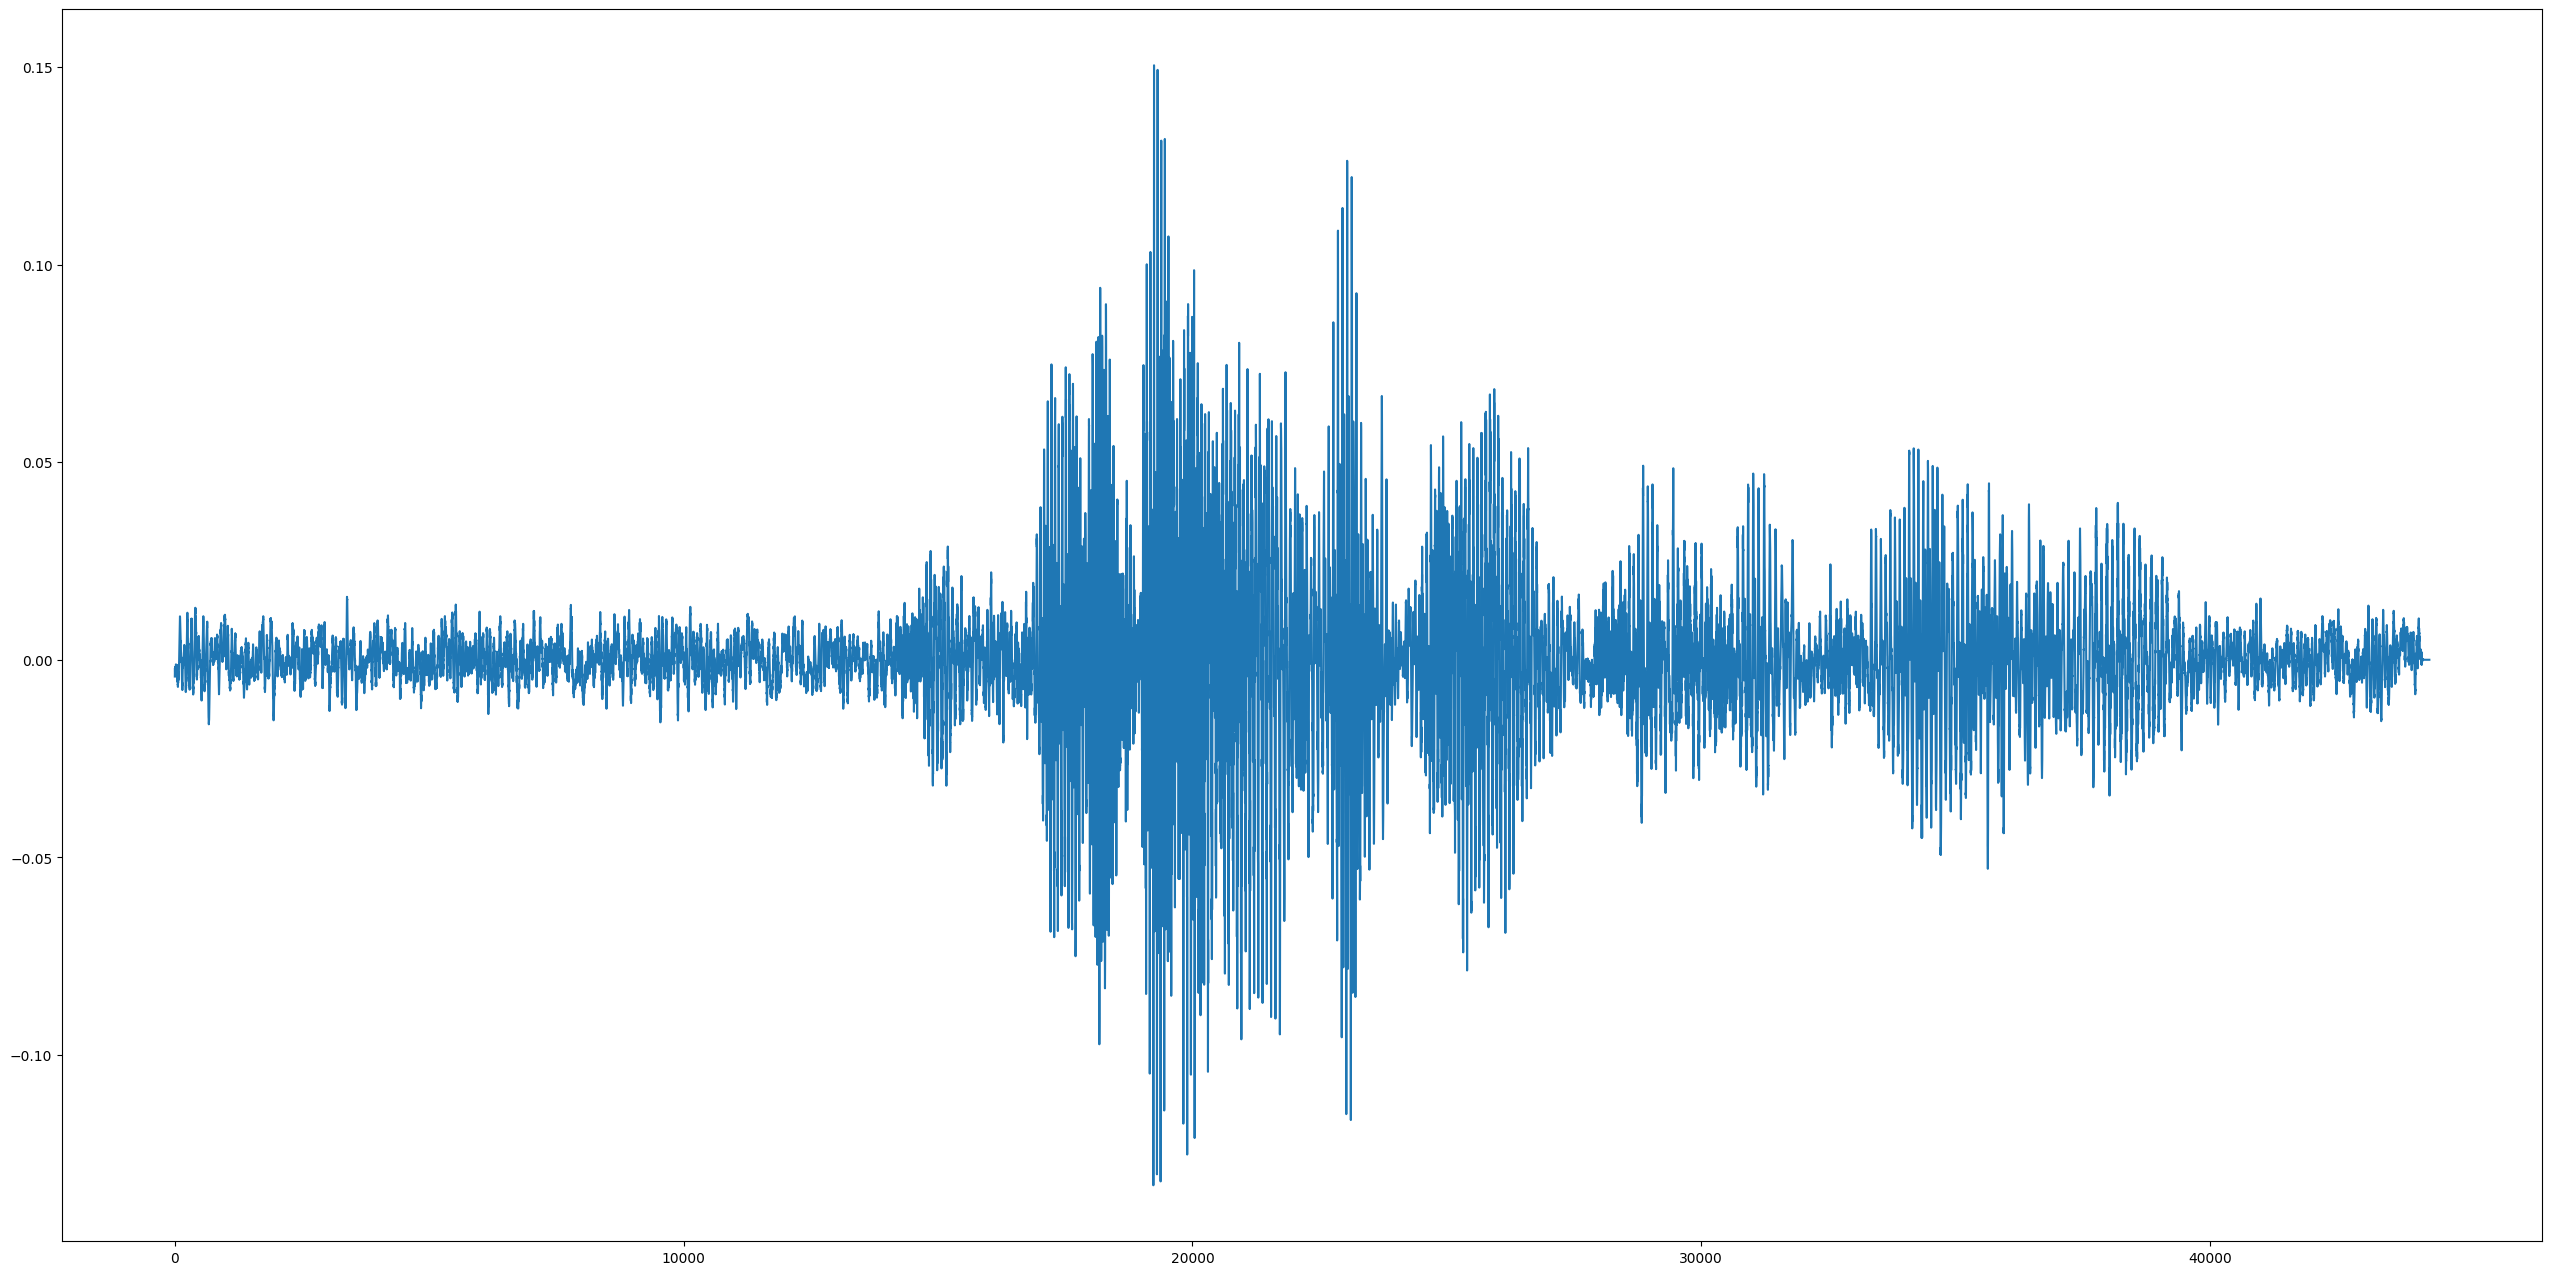

In [ ]:
instance = train_dataset[0]
plt.figure(figsize=(32, 16))
plt.plot(instance["x"])

display.Audio(instance["x"], rate=dataset.SAMPLE_RATE)

In [ ]:
class PaddingCollator:
    def __call__(self, instances) -> dict[str, Any]:
        batch_size = len(instances)
         # Вычисляем длину каждого экземпляра "x" и "y"
        x_len = torch.LongTensor([instance["x"].size(0) for instance in instances])
        y_len = torch.LongTensor([instance["y"].size(0) for instance in instances])
        path = [instance["path"] for instance in instances]
# Создаем тензоры с нулевыми значениями для "x" и "y", с размером, соответствующим максимальной длине
        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)
        y.fill_(10)
 # Копируем данные из экземпляров в тензоры "x" и "y"
        for i, instance in enumerate(instances):
            x[i, : x_len[i]] = instance["x"]
            y[i, : y_len[i]] = instance["y"]
# Собираем все данные в словарь
        instance = {"x": x, "y": y, "x_len": x_len, "y_len": y_len, "path": path}

        return instance
 # Создаем DataLoader для обучающего набора данных
train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    collate_fn=PaddingCollator(),
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=PaddingCollator(), pin_memory=True
)
batch = list(islice(val_dataloader, 1))[0]
batch

{'x': tensor([[-0.0058, -0.0067, -0.0073,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0104, -0.0088, -0.0088,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0043, -0.0042, -0.0041,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.0029, -0.0056, -0.0059,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0004, -0.0007,  0.0001,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0022,  0.0023,  0.0024,  ...,  0.0004,  0.0004,  0.0004]]),
 'y': tensor([[ 73, 116,  39,  ...,  10,  10,  10],
         [ 73,  39, 109,  ...,  10,  10,  10],
         [ 84, 104, 101,  ...,  10,  10,  10],
         ...,
         [ 73, 116,  39,  ...,  10,  10,  10],
         [ 73,  32, 119,  ...,  10,  10,  10],
         [ 73, 116,  39,  ...,  10,  10,  10]]),
 'x_len': tensor([30430, 41108, 58725, 47514, 33100, 39506, 40574, 44311, 58191, 61929,
         34167, 34167, 31498, 34167, 39506, 63530, 46980, 40040, 47514, 32566,
         45379, 44845, 47514, 46980, 27761, 30964, 41108, 38438, 35235, 40040,
    

In [ ]:
from torchaudio.transforms import MelSpectrogram

featurizer = MelSpectrogram(
    sample_rate=train_dataset.dataset.SAMPLE_RATE,#Устанавливает частоту дискретизации аудиосигнала (в Гц), обычно определяемую в наборе данных.
    n_fft=512,#Устанавливает размер окна для преобразования Фурье (в точках).
    win_length=512,# Устанавливает длину окна (в точках), используемого для вычисления преобразования Фурье.
    hop_length=512,#Устанавливает смещение окна (в точках), используемое для вычисления преобразования Фурье.
    n_mels=64,#Устанавливает количество мел-полос для мел-спектрограммы.
    power=1,#Устанавливает степень преобразования (по умолчанию - 2)
)


def apply_compression(melspec):
    return torch.log(melspec.clamp(1e-5))

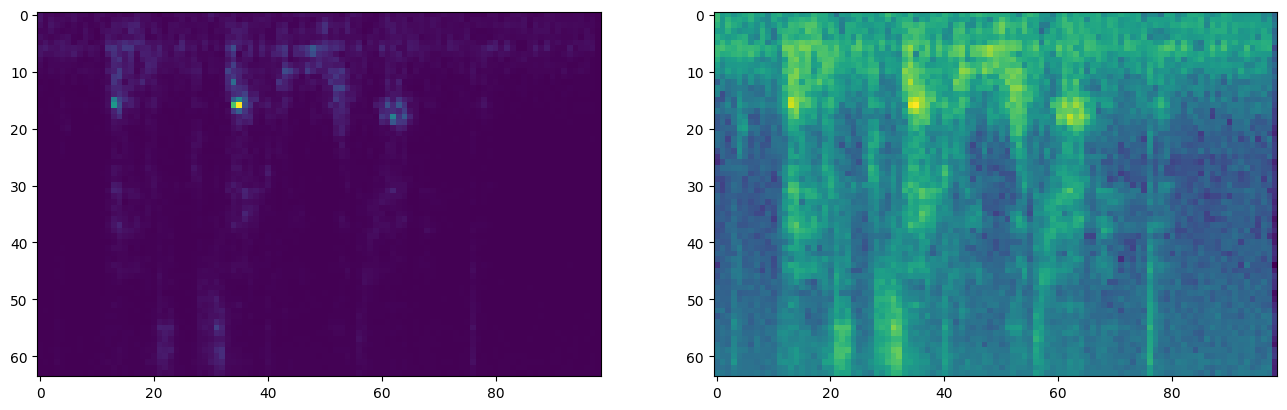

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(featurizer(wav))
axes[1].imshow(apply_compression(featurizer(wav)));

3.


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=87
  warnings.warn(


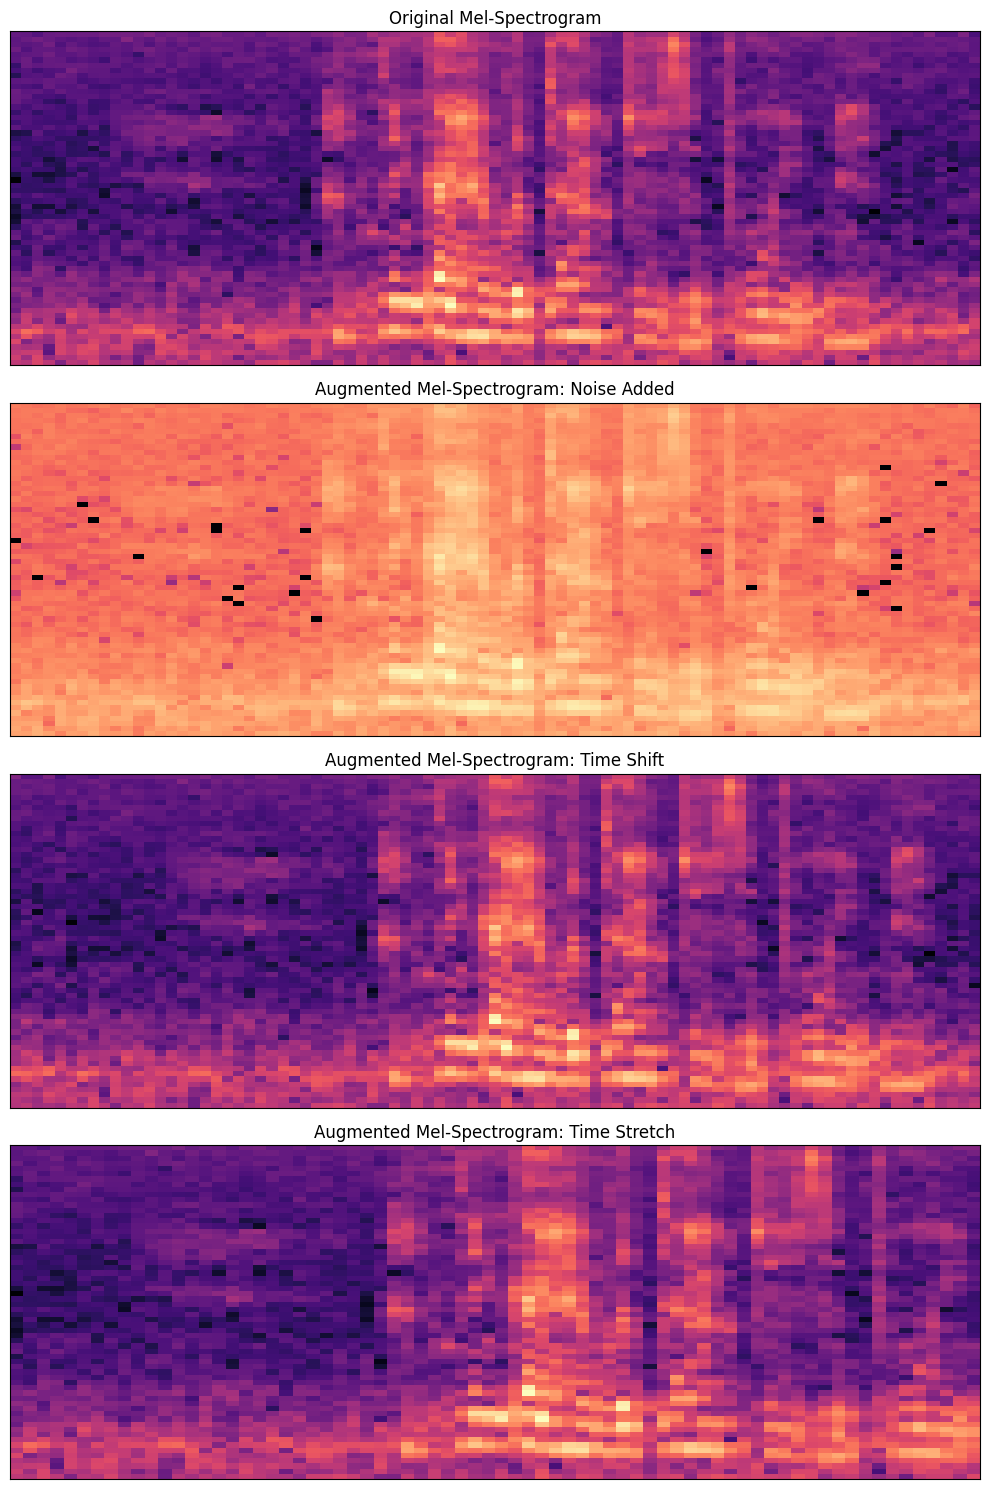

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Применение аугментации
def augment_mel_spec(mel_spec):

    # 1. Добавление шума
    noise = np.random.randn(*mel_spec.shape) * 0.01
    augmented1 = mel_spec + noise

    # 2. Time shift
    shift = np.roll(mel_spec, shift=5, axis=1)

    # 3. Time stretch
    stretch = librosa.effects.time_stretch(mel_spec, rate=1.2)

    return augmented1, shift, stretch


#Пример1
instance = train_dataset[0]
wav = instance["x"]
melspec = np.array(featurizer(wav))
augmented_specs = augment_mel_spec(melspec)

# Визуализация оригинальной и аугментированной мел-спектрограмм
fig, axs = plt.subplots(4, 1, figsize=(10, 15))

# Оригинальная мел-спектрограмма
librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max), ax=axs[0])
axs[0].set_title('Original Mel-Spectrogram')

# Аугментация 1: Добавление шума
librosa.display.specshow(librosa.power_to_db(augmented_specs[0], ref=np.max), ax=axs[1])
axs[1].set_title('Augmented Mel-Spectrogram: Noise Added')

# Аугментация 2: Time shift
librosa.display.specshow(librosa.power_to_db(augmented_specs[1], ref=np.max), ax=axs[2])
axs[2].set_title('Augmented Mel-Spectrogram: Time Shift')

# Аугментация 3: Time stretch
librosa.display.specshow(librosa.power_to_db(augmented_specs[2], ref=np.max), ax=axs[3])
axs[3].set_title('Augmented Mel-Spectrogram: Time Stretch')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=83
  warnings.warn(


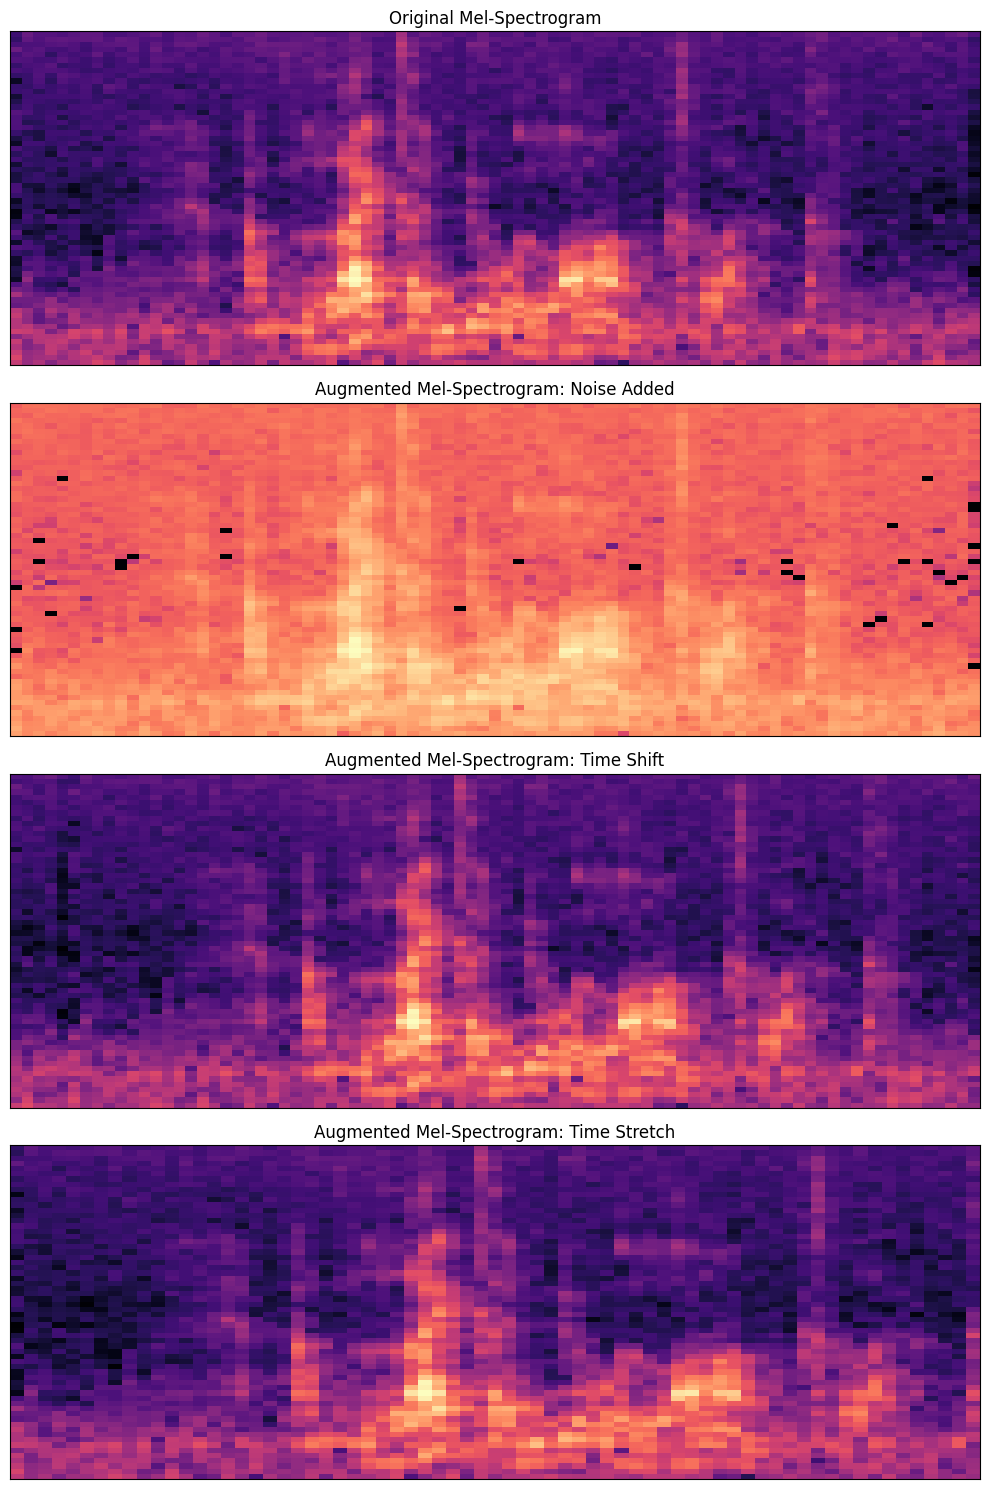

In [ ]:
#Пример 2
instance = train_dataset[45]
wav = instance["x"]
melspec = np.array(featurizer(wav))
augmented_specs = augment_mel_spec(melspec)

# Визуализация оригинальной и аугментированной мел-спектрограмм
fig, axs = plt.subplots(4, 1, figsize=(10, 15))

# Оригинальная мел-спектрограмма
librosa.display.specshow(librosa.power_to_db(melspec, ref=np.max), ax=axs[0])
axs[0].set_title('Original Mel-Spectrogram')

# Аугментация 1: Добавление шума
librosa.display.specshow(librosa.power_to_db(augmented_specs[0], ref=np.max), ax=axs[1])
axs[1].set_title('Augmented Mel-Spectrogram: Noise Added')

# Аугментация 2: Time shift
librosa.display.specshow(librosa.power_to_db(augmented_specs[1], ref=np.max), ax=axs[2])
axs[2].set_title('Augmented Mel-Spectrogram: Time Shift')

# Аугментация 3: Time stretch
librosa.display.specshow(librosa.power_to_db(augmented_specs[2], ref=np.max), ax=axs[3])
axs[3].set_title('Augmented Mel-Spectrogram: Time Stretch')

plt.tight_layout()
plt.show()